# Business Understanding

# Data Engineering

## Import Libraries

In [659]:
# import libraries required to load, transform, analyze and model data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import string
import re

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import en_core_web_sm
from spacy.tokenizer import _get_regex_pattern
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from keras.preprocessing import text, sequence
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as k
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [2]:
# remove scientific notation and restrictions on df rows/columns display
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('display.max_colwidth', 150)

## Dataframe Basics

### Load File

In [3]:
# load primary source file to df, renaming columns, dropping non-ASCII
col_names = ['tweet_text', 'directed_at', 'emotion_label']
tweets = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape', names=col_names, header=0)
tweets.head()

,tweet_text,directed_at,emotion_label
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


### Data Values

In [4]:
# review data types and null counts
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet_text     9092 non-null   object
 1   directed_at    3291 non-null   object
 2   emotion_label  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
# drop nan tweets from dataframe
tweets.dropna(subset = ['tweet_text'], inplace=True)
tweets.shape

(9092, 3)

In [6]:
# check value counts by directed_at
print(tweets['directed_at'].value_counts(normalize=True, dropna=False))

NaN                               0.638
iPad                              0.104
Apple                             0.073
iPad or iPhone App                0.052
Google                            0.047
iPhone                            0.033
Other Google product or service   0.032
Android App                       0.009
Android                           0.009
Other Apple product or service    0.004
Name: directed_at, dtype: float64


In [7]:
# create brand feature, mapping directed_at to Apple, Google or None
tweets['directed_at'].fillna('None', inplace=True)
brand_map = {'iPad': 'Apple', 'Apple': 'Apple', 'iPad or iPhone App': 'Apple', 
             'Google': 'Google', 'iPhone': 'Apple', 
             'Other Google product or service': 'Google',
            'Android App': 'Google', 'Android': 'Google',
             'Other Apple product or service': 'Apple',
             'None': 'None'
            }
tweets['brand'] = tweets.directed_at.map(brand_map, na_action='ignore')

In [8]:
# simplify emotion labels to Positive, Negative or Neutral
tweets['emotion_label'].replace({'No emotion toward brand or product': 'Neutral',
                                 'Positive emotion': 'Positive', 
                                 'Negative emotion': 'Negative', 
                                 'I can\'t tell': 'Unknown'}, inplace=True)

# check value distribution by emotion
print(tweets['emotion_label'].value_counts(normalize=True, dropna=False))

Neutral    0.593
Positive   0.328
Negative   0.063
Unknown    0.017
Name: emotion_label, dtype: float64


In [9]:
# check value distribution by emotion witin brand
tweets.groupby(by=['brand', 'emotion_label'])['tweet_text'].count()

brand   emotion_label
Apple   Negative          388
        Neutral            65
        Positive         1949
        Unknown             7
Google  Negative          131
        Neutral            26
        Positive          723
        Unknown             2
None    Negative           51
        Neutral          5297
        Positive          306
        Unknown           147
Name: tweet_text, dtype: int64

## Tweet Text Clean

In [660]:
def remove_punctuation(x):
    """
    Helper function removes punctuation, numbers, urls, and @mentions from a 
    string. Leaves hastags in place.
    
    Parameter | x (str): text string of any length
    Returns | x (str): same string cleaned
    """
    punctuation = set(string.punctuation) # set of punctuation - english
    punctuation.remove('#') # remove "#" so hashtags remain in tweet text

    x = re.sub('@[A-Za-z0-9]+', '', x) # remove @mention users
    x = re.sub(r'http\S+', '', x) # remove url references
    x = re.sub(r'\b[0-9]+\b', '', x) # remove stand-alone numbers  
    x = ''.join(ch for ch in x if ch not in punctuation) # remove punctuation
    return x

In [662]:
def clean_text(df, text_field, new_text_field):
    """
    Function inserts a new DataFrame series with punctuation removed while 
    retaining original series.
    
    Parameter | df (DataFrame): dataframe
    Parameter | text_field (Series): column to transform
    Parameter | new_text_field (Series): new, cleaned column    
    Returns | df (DataFrame): dataframe with new column
    """
    df[new_text_field] = df[text_field].str.lower()
    df[new_text_field] = df[new_text_field].apply(remove_punctuation) 
    return df

In [663]:
# create new dataframe with cleaned tweet text
tweets_clean = clean_text(tweets, 'tweet_text', 'tweet_text_clean')
tweets_clean.head()

,tweet_text,directed_at,emotion_label,brand,tweet_text_clean,tokens_sp
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,Apple,i have a 3g iphone after hrs tweeting at #riseaustin it was dead i need to upgrade plugin stations at #sxsw,"[g, iphone, hrs, tweet, #riseaustin, dead, need, upgrade, plugin, station, #sxsw]"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,Apple,know about awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at #sxsw,"[know, awesome, ipadiphone, app, will, likely, appreciate, design, give, free, ts, #sxsw]"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,Apple,can not wait for #ipad also they should sale them down at #sxsw,"[wait, #ipad, sale, #sxsw]"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,Apple,i hope this years festival isnt as crashy as this years iphone app #sxsw,"[hope, year, festival, not, crashy, year, iphone, app, #sxsw]"
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,Google,great stuff on fri #sxsw marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress,"[great, stuff, fri, #sxsw, marissa, mayer, google, tim, oreilly, tech, booksconference, amp, matt, mullenweg, wordpress]"


In [664]:
# instantiate spacy natural language processing object
nlp = en_core_web_sm.load()

# get default pattern for tokens that don't get split
re_token_match = _get_regex_pattern(nlp.Defaults.token_match)

# add my patterns (here: hashtags and in-word hyphens)
re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"

# overwrite token_match function of the spacy tokenizer
nlp.tokenizer.token_match = re.compile(re_token_match).match

In [665]:
# create tokens_sp with word lemmas as tokens, stripped of stopwords
stops_sp = nlp.Defaults.stop_words
print(f'spaCy Stopword Count: {len(stops_sp)}')

def clean_token(doc):
    return [token.lemma_ for token in doc if not token.is_stop 
            and not token.is_punct and not token.is_digit 
            and not token.is_space]

tweets['tokens_sp'] = [clean_token(nlp(row)) for row in tweets.tweet_text_clean.apply(str)]

tweets.head()

spaCy Stopword Count: 326


,tweet_text,directed_at,emotion_label,brand,tweet_text_clean,tokens_sp
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,Apple,i have a 3g iphone after hrs tweeting at #riseaustin it was dead i need to upgrade plugin stations at #sxsw,"[g, iphone, hrs, tweet, #riseaustin, dead, need, upgrade, plugin, station, #sxsw]"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,Apple,know about awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at #sxsw,"[know, awesome, ipadiphone, app, will, likely, appreciate, design, give, free, ts, #sxsw]"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,Apple,can not wait for #ipad also they should sale them down at #sxsw,"[wait, #ipad, sale, #sxsw]"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,Apple,i hope this years festival isnt as crashy as this years iphone app #sxsw,"[hope, year, festival, not, crashy, year, iphone, app, #sxsw]"
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,Google,great stuff on fri #sxsw marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress,"[great, stuff, fri, #sxsw, marissa, mayer, google, tim, oreilly, tech, booksconference, amp, matt, mullenweg, wordpress]"


In [666]:
# create dictionary of token counts and print top 10
word_dict = {}

# Loop through all the tags
for i, row in tweets['tokens_sp'].iteritems():
    for word in row:
        if word not in word_dict:
            word_dict[word] = 1
        else:
            word_dict[word] +=1

word_counts = sorted(word_dict.items(), key=lambda kv: kv[1], reverse=True)
print(f'Total words: {len(word_counts)}')
word_counts[:10]

Total words: 9533


[('#sxsw', 8947),
 ('link', 4300),
 ('rt', 2953),
 ('ipad', 2245),
 ('google', 2102),
 ('apple', 1826),
 ('store', 1501),
 ('iphone', 1258),
 ('new', 1093),
 ('app', 992)]

## Tweet Cloud

In [667]:
# importing twitter logo images as mask for wordcloud
twitter_mask = np.array(Image.open('images/twitter_mask.png'))

In [694]:
# word tokenize and lowercase all words 
neg_tweets = " ".join(tweet for tweet in tweets[tweets.emotion_label == 'Negative'].tweet_text_clean.astype(str))
pos_tweets = " ".join(tweet for tweet in tweets[tweets.emotion_label == 'Positive'].tweet_text_clean.astype(str))

In [695]:
# isolate words that are uniquely associated to negative or positive tweets
neg_words = set(neg_tweets.split(' '))-set(pos_tweets.split(' '))
neg_words_str = " ".join(word for word in neg_words)
pos_words = set(pos_tweets.split(' '))-set(neg_tweets.split(' '))
pos_words_str = " ".join(word for word in pos_words)

In [704]:
tweets[(tweets['brand']=='Apple') & (tweets['emotion_label']=='Negative')]

,tweet_text,directed_at,emotion_label,brand,tweet_text_clean,tokens_sp
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,Apple,i have a 3g iphone after hrs tweeting at #riseaustin it was dead i need to upgrade plugin stations at #sxsw,"[g, iphone, hrs, tweet, #riseaustin, dead, need, upgrade, plugin, station, #sxsw]"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,Apple,i hope this years festival isnt as crashy as this years iphone app #sxsw,"[hope, year, festival, not, crashy, year, iphone, app, #sxsw]"
17,I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone,iPhone,Negative,Apple,i just noticed dst is coming this weekend how many iphone users will be an hour late at sxsw come sunday morning #sxsw #iphone,"[notice, dst, come, weekend, iphone, user, hour, late, sxsw, come, sunday, morning, #sxsw, #iphone]"
67,attending @mention iPad design headaches #sxsw {link},iPad,Negative,Apple,attending ipad design headaches #sxsw link,"[attend, ipad, design, headache, #sxsw, link]"
92,What !?!? @mention #SXSW does not provide iPhone chargers?!? I've changed my mind about going next year!,iPhone,Negative,Apple,what #sxsw does not provide iphone chargers ive changed my mind about going next year,"[#sxsw, provide, iphone, charger, have, change, mind, go, year]"
...,...,...,...,...,...,...
8855,"If there was a popup store in Austin that sold nothing but iPhone battery extenders, it would make so much money. #sxsw",iPhone,Negative,Apple,if there was a popup store in austin that sold nothing but iphone battery extenders it would make so much money #sxsw,"[popup, store, austin, sell, iphone, battery, extender, money, #sxsw]"
8930,#iPad #news #apps not popular with the #kids. {link} #the_daily is a terrible concept anyway #sxsw,iPad or iPhone App,Negative,Apple,#ipad #news #apps not popular with the #kids link #thedaily is a terrible concept anyway #sxsw,"[#ipad, #news, #apps, popular, #kids, link, #thedaily, terrible, concept, #sxsw]"
8943,Hmmm...Taxi Magic on iPhone does not appear to be so magic any more in Austin #sxsw,iPad or iPhone App,Negative,Apple,hmmmtaxi magic on iphone does not appear to be so magic any more in austin #sxsw,"[hmmmtaxi, magic, iphone, appear, magic, austin, #sxsw]"
8981,I think my effing hubby is in line for an #iPad 2. Can someone point him towards the line-up for wife number #2. #sxswi #sxsw,iPad,Negative,Apple,i think my effing hubby is in line for an #ipad can someone point him towards the lineup for wife number # #sxswi #sxsw,"[think, eff, hubby, line, #ipad, point, lineup, wife, number, #sxswi, #sxsw]"


In [707]:
def CountOccurrences(my_set):
    counts = {}
    for word in my_set:
        if word not in counts:
            counts[word] = 0
        counts[word] += 1
    return counts

In [708]:
CountOccurrences(pos_words)

{'#unsix': 1,
 'bound': 1,
 'mappers': 1,
 '#wssxsw': 1,
 'lug': 1,
 'slow': 1,
 'wmost': 1,
 'elements': 1,
 'rematch': 1,
 'globalbestaward': 1,
 '250k': 1,
 'mp3': 1,
 'creatively': 1,
 'spotted': 1,
 '#heattracker': 1,
 'leisurely': 1,
 'monitor': 1,
 'catch': 1,
 '#4sq3': 1,
 'docs': 1,
 'aos': 1,
 'landscapes': 1,
 'bugger': 1,
 'ipads#sxsw': 1,
 'hunger': 1,
 'emails': 1,
 '#zappos': 1,
 '#newapplestoreaustin': 1,
 'connected': 1,
 'ip': 1,
 'surface': 1,
 'tramplings': 1,
 'teo': 1,
 'owl': 1,
 'api': 1,
 'yup': 1,
 'refine': 1,
 '#mophie': 1,
 'surui': 1,
 'track': 1,
 'instant': 1,
 '#pushio': 1,
 'omg': 1,
 'ninjafinder': 1,
 'ossum': 1,
 'mothers': 1,
 'nyts': 1,
 'throwin': 1,
 'invites': 1,
 'dynamic': 1,
 'gain': 1,
 'cohosting': 1,
 'relaxed': 1,
 'spazmatics': 1,
 'overshadowing': 1,
 'wires': 1,
 'debuts': 1,
 'discovered': 1,
 'economyquot': 1,
 'heavenly': 1,
 'cute': 1,
 '#videos': 1,
 'cks': 1,
 'blog': 1,
 'ups': 1,
 'games': 1,
 'agents': 1,
 'copia': 1,
 'mealt

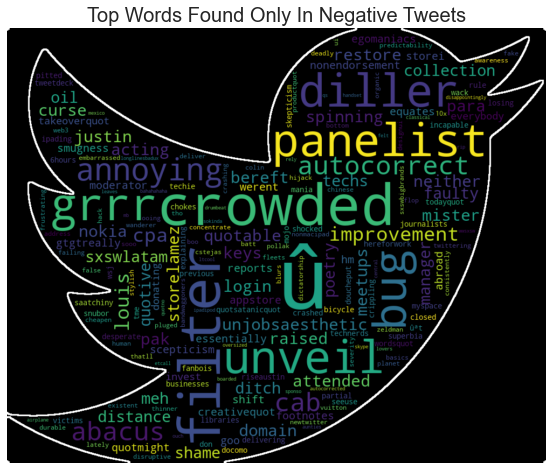

In [696]:
# generating a wordcloud with a twitter mask for positive words only 
wordcloud1 = WordCloud(collocations=False, mask=twitter_mask, 
                      background_color='black', width=600,
                      height=485, contour_color='white', contour_width=4)

wordcloud1.generate(neg_words_str)

plt.figure(figsize = (10, 8), facecolor = 'white') 
plt.imshow(wordcloud1, interpolation='bilinear')
plt.title('Top Words Found Only In Negative Tweets', size=20)
plt.axis('off')
plt.show()

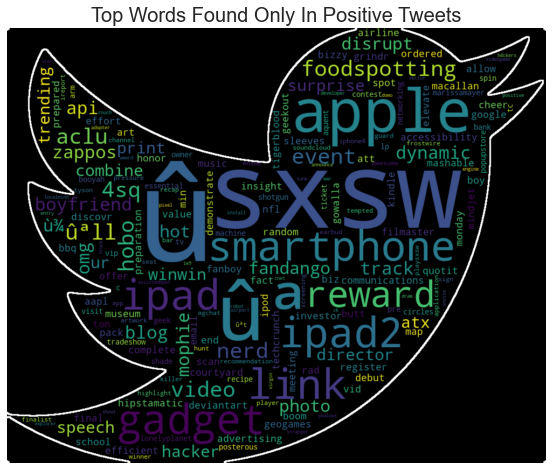

In [698]:
# generating a wordcloud with a twitter mask for negative words only 
wordcloud2 = WordCloud(collocations=False, mask=twitter_mask, 
                      background_color='black', width=600,
                      height=485, contour_color='white', contour_width=4)

wordcloud2.generate(pos_words_str)

plt.figure(figsize = (10, 8), facecolor = 'white') 
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('Top Words Found Only In Positive Tweets', size=20)
plt.axis('off')
plt.show()

# Data Analysis

# Predictive Models

## Train-Test Split

In [549]:
# filter tweets for identifiable emotions only (drop unknown)
SEED = 19
sentiments = ['Positive', 'Negative', 'Neutral']
tweets_f = tweets[tweets['emotion_label'].isin(sentiments)]

# create X and y (one-hot encoded for 3 classes)
Xt = tweets_f['tokens_sp']
X = tweets_f['tweet_text_clean']
y = pd.get_dummies(tweets_f['emotion_label'])
print(X.iloc[:3], y.iloc[:3])

0           i have a 3g iphone after  hrs tweeting at #riseaustin it was dead  i need to upgrade plugin stations at #sxsw
1     know about   awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at #sxsw
2                                                        can not wait for #ipad  also they should sale them down at #sxsw
Name: tweet_text_clean, dtype: object    Negative  Neutral  Positive
0         1        0         0
1         0        0         1
2         0        0         1


In [356]:
def TrainTestSplit(X, y):
    # keras tokenize sequences with padding
    t = text.Tokenizer(oov_token=1)
    t.fit_on_texts(X)
    X_seq = t.texts_to_sequences(X)
    X_seq_pad = sequence.pad_sequences(X_seq, padding='post') 
    X_seq_df = pd.DataFrame(data=X_seq_pad, index=X.index.copy())
   
    # Split into training and test sets for cleaned text
    SEED = 19
    X_train, X_test, y_train, y_test = train_test_split(
        X_seq_df, y, test_size=0.20, stratify=y, random_state=SEED)

    print(f'X_train: {X_train.shape} X_test: {X_test.shape} ' 
          f'y_train: {y_train.shape} y_test: {y_test.shape}')

    # set parameters for model input
    doc_cnt = X_train.shape[0]
    vocab_size = len(t.word_index)+1
    input_length = X_train.shape[1]

    print(f'Document count: {doc_cnt} | '
          f'Vocab size: {vocab_size} | '
          f'Input length: {input_length} '
         )
    return t, X_train, X_test, y_train, y_test, doc_cnt, vocab_size, input_length

In [357]:
#
X_tok, X_train, X_test, y_train, y_test, doc_cnt, vocab_size, input_length = TrainTestSplit(X, y)

X_train: (7148, 30) X_test: (1788, 30) y_train: (7148, 3) y_test: (1788, 3)
Document count: 7148 | Vocab size: 10565 | Input length: 30 


In [550]:
#
Xt_tok, Xt_train, Xt_test, yt_train, yt_test, doc_cnt2, vocab_size2, \
    input_length2 = TrainTestSplit(Xt, y)

X_train: (7148, 23) X_test: (1788, 23) y_train: (7148, 3) y_test: (1788, 3)
Document count: 7148 | Vocab size: 9435 | Input length: 23 


## Model Functions

In [255]:
def plot_accuracy(history, model_name):
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title(f'Model Accuracy: {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

In [281]:
def predict(model, X, y_true):
    classes = ['Negative', 'Neutral', 'Positive']
    y_hat = model.predict(X)
    y_hat_cl = pd.DataFrame((y_hat == y_hat.max(axis=1, 
                                                keepdims=True)).astype(int), 
                                                columns=classes,
                                                index=X.index.copy())
    y_hat = pd.DataFrame(y_hat,columns=classes, index=X.index.copy())
    return y_hat, y_hat_cl

In [241]:
def create_pred_class(y):
    y_piv = y.copy()
    y_piv['pred_class'] = y_piv.apply(lambda row: 
                                      pivot_predictions(row.Negative, 
                                                        row.Neutral, 
                                                        row.Positive), 
                                      axis=1)
    return y_piv

In [213]:
def pivot_predictions(neg, neut, pos):
    pred_class = 'Unknown'
    if neg == 1:
        pred_class = 'Negative'
    elif neut == 1:
        pred_class = 'Neutral'
    elif pos == 1:
        pred_class = 'Positive'
    return pred_class

In [248]:
# Plot confusion matrix 
def plot_confusion(y_true, y_hat, model_name):   
    cnf_matrix  = confusion_matrix(y_true, y_hat)
    cmap = plt.get_cmap('Blues')
    cmd = ConfusionMatrixDisplay(cnf_matrix, 
                                 display_labels=['Negative', 'Neutral', 
                                                 'Positive'])
    cmd.plot(cmap=cmap)
    plt.title(f'Confusion Matrix for Model: {model_name}')
    plt.tight_layout()
    plt.show()
    print(classification_report(y_true, y_hat))
    return cnf_matrix

## m0 - SVM

In [645]:
SEED = 19
y_m0 = tweets_f['emotion_label']
X_train_m0, X_test_m0, y_train_m0, y_test_m0 = train_test_split(X, y_m0, 
                                                    test_size=0.20, 
                                                    stratify=y, 
                                                    random_state=SEED)

In [647]:
# Create feature vectors
vectorizer = TfidfVectorizer(stop_words='english')
train_vectors = vectorizer.fit_transform(X_train_m0)
test_vectors = vectorizer.transform(X_test_m0)

In [648]:
# instantiate SVC()
svc = SVC(kernel='linear', class_weight='balanced')

In [651]:
svc.fit(train_vectors, y_train_m0)

SVC(class_weight='balanced', kernel='linear')

In [652]:
y_train_hat_m0 = svc.predict(train_vectors)

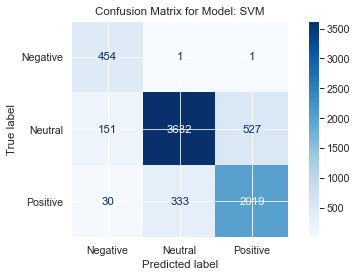

              precision    recall  f1-score   support

    Negative       0.71      1.00      0.83       456
     Neutral       0.92      0.84      0.88      4310
    Positive       0.79      0.85      0.82      2382

    accuracy                           0.85      7148
   macro avg       0.81      0.90      0.84      7148
weighted avg       0.86      0.85      0.86      7148



In [655]:
# plot confusion matrix and classification report
cnf_matrix_train_m0 = plot_confusion(y_train_m0, 
                               y_train_hat_m0,
                               'SVM')

In [656]:
y_test_hat_m0 = svc.predict(test_vectors)

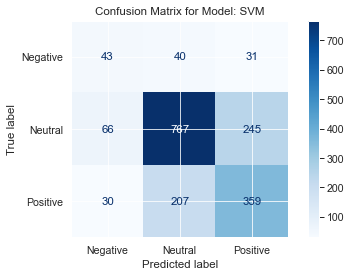

              precision    recall  f1-score   support

    Negative       0.31      0.38      0.34       114
     Neutral       0.76      0.71      0.73      1078
    Positive       0.57      0.60      0.58       596

    accuracy                           0.65      1788
   macro avg       0.54      0.56      0.55      1788
weighted avg       0.66      0.65      0.66      1788



In [657]:
# plot confusion matrix and classification report
cnf_matrix_test_m0 = plot_confusion(y_test_m0, 
                               y_test_hat_m0,
                               'SVM')

## m1 - LSTM Embed Tweets Cleaned

In [608]:
# instantiate keras sequential LSTM model layers with embeddings
m1 = Sequential(name="m1_seq_lstm")
m1.add(Embedding(input_dim=vocab_size, 
                    output_dim=128, 
                    input_length=input_length
                    ))
m1.add(LSTM(64, return_sequences=True))
m1.add(GlobalMaxPool1D()) # downsamples input by taking the maximum value over the time dimension
m1.add(Dropout(0.15)) # drop out lower or remove (regularization)
m1.add(Dense(32, activation='relu'))
m1.add(Dense(3, activation='softmax'))

In [609]:
# compile model and print summary
m1.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
m1.summary()

Model: "m1_seq_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 30, 128)           1352320   
_________________________________________________________________
lstm_15 (LSTM)               (None, 30, 64)            49408     
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 64)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 99        
Total params: 1,403,907
Trainable params: 1,403,907
Non-trainable params: 0
_____________________________________________

In [610]:
# Define the callbacks, early stopping and save final model
early_stop_m1 = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), 
                  ModelCheckpoint(filepath='best_model_m1.h5', monitor='val_loss',
                                  save_best_only=True)]
class_weights_m1 = [{0: 1, 1: 9}, {0: 1, 1: 1}, {0: 1, 1: 2}]

m1_fit = m1.fit(X_train, y_train, epochs=50, callbacks=early_stop_m1, class_weight=class_weights_m1,
       validation_split=0.15, shuffle=True, batch_size=128)

/Users/cutterback/opt/anaconda3/envs/p37env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6075 samples, validate on 1073 samples
Epoch 1/50
6075/6075 [==============================] - 10s 2ms/step - loss: 0.9030 - accuracy: 0.5755 - val_loss: 0.8390 - val_accuracy: 0.5983
Epoch 2/50
6075/6075 [==============================] - 9s 1ms/step - loss: 0.7839 - accuracy: 0.6362 - val_loss: 0.7324 - val_accuracy: 0.6608
Epoch 3/50
6075/6075 [==============================] - 8s 1ms/step - loss: 0.5833 - accuracy: 0.7607 - val_loss: 0.7068 - val_accuracy: 0.6803
Epoch 4/50
6075/6075 [==============================] - 8s 1ms/step - loss: 0.4043 - accuracy: 0.8486 - val_loss: 0.7635 - val_accuracy: 0.6850
Epoch 5/50
6075/6075 [==============================] - 9s 1ms/step - loss: 0.3068 - accuracy: 0.8858 - val_loss: 0.8076 - val_accuracy: 0.6878
Epoch 6/50
6075/6075 [==============================] - 9s 1ms/step - loss: 0.2404 - accuracy: 0.9091 - val_loss: 0.8961 - val_accuracy: 0.7008


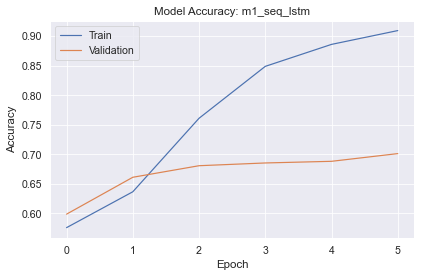

In [611]:
# extract history from model and plot epoch accuracy trend
m1_hist = m1_fit.history
plot_accuracy(m1_hist, m1.name)

In [612]:
# create predictions for model
y_train_hat_m1, y_train_hat_cl_m1 = predict(m1, X_train, y_train)

In [613]:
# pivot 3 multi-labels into single class column to feed confusion matrix
y_train_piv = create_pred_class(y_train)
y_train_hat_cl_m1_piv = create_pred_class(y_train_hat_cl_m1)

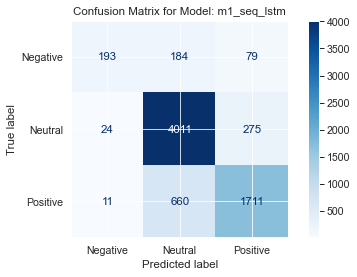

              precision    recall  f1-score   support

    Negative       0.85      0.42      0.56       456
     Neutral       0.83      0.93      0.88      4310
    Positive       0.83      0.72      0.77      2382

    accuracy                           0.83      7148
   macro avg       0.83      0.69      0.74      7148
weighted avg       0.83      0.83      0.82      7148



In [614]:
# plot confusion matrix and classification report
cnf_matrix_train_m1 = plot_confusion(y_train_piv.pred_class, 
                               y_train_hat_cl_m1_piv.pred_class,
                               m1.name)

In [574]:

Xy_train_m1 = pd.concat([y_train_piv.iloc[:, 3], y_train_hat_cl_m1_piv.iloc[:, 3], y_train_hat_m1, X], axis=1, join='inner')
Xy_train_m1.columns.values[0] = 'act_class'
Xy_train_m1.columns.values[2] = 'p_negative'
Xy_train_m1.columns.values[3] = 'p_neutral'
Xy_train_m1.columns.values[4] = 'p_positive'
Xy_train_m1

,act_class,pred_class,p_negative,p_neutral,p_positive,tweet_text_clean
6929,Neutral,Neutral,0.007,0.943,0.050,rt who is flying to #sxsw and wants some free miles dm meill shoot you a code currently iphone only
5841,Neutral,Neutral,0.006,0.948,0.046,rt google launching secret new social network called quotcirclesquot link #sxsw
2865,Negative,Positive,0.107,0.177,0.716,google prefers to launch hyped new social features with meh not bang via tc link #sxsw
4306,Neutral,Neutral,0.027,0.870,0.103,luv rt best thing i heard this wknd at #sxsw quoti gave my ipad money to #japan relief dont need ipad quot
8888,Positive,Positive,0.109,0.306,0.585,i wish i were at #sxsw i wish i had an ipad there i said it
...,...,...,...,...,...,...
4594,Neutral,Neutral,0.007,0.930,0.063,money money money #apple heads to #sxsw sets up temporary store in austin link via
6975,Neutral,Positive,0.078,0.454,0.468,rt wow leo just told a random person on the street he would send her an ipad #twit #sxsw
7700,Neutral,Neutral,0.023,0.852,0.125,false alarm google circles not coming nowûòand probably not ever link more link #sxsw #sxswi
1476,Positive,Positive,0.100,0.140,0.760,brilliant rt apple set to open popup shop in core of sxsw action theyre going to sell ipad2 at #sxsw link


In [615]:
# create predictions for model
y_test_hat_m1, y_test_hat_cl_m1 = predict(m1, X_test, y_test)

In [616]:
# pivot 3 multi-labels into single class column to feed confusion matrix
y_test_piv = create_pred_class(y_test)
y_test_hat_cl_m1_piv = create_pred_class(y_test_hat_cl_m1)

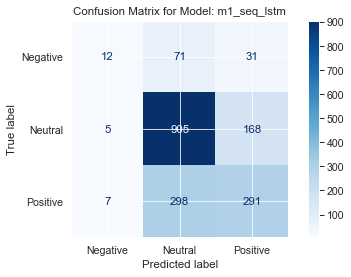

              precision    recall  f1-score   support

    Negative       0.50      0.11      0.17       114
     Neutral       0.71      0.84      0.77      1078
    Positive       0.59      0.49      0.54       596

    accuracy                           0.68      1788
   macro avg       0.60      0.48      0.49      1788
weighted avg       0.66      0.68      0.65      1788



In [617]:
# plot confusion matrix and classification report
cnf_matrix_test_m1 = plot_confusion(y_test_piv.pred_class, 
                               y_test_hat_cl_m1_piv.pred_class,
                               m1.name)

## m2 - LSTM Embed Tweet Tokens

In [618]:
# instantiate keras sequential LSTM model layers with embeddings
m2 = Sequential(name="m2_seq_lstm")
m2.add(Embedding(input_dim=vocab_size2, 
                    output_dim=128, 
                    input_length=input_length2
                    ))
m2.add(LSTM(64, return_sequences=True))
m2.add(GlobalMaxPool1D()) # downsamples input by taking the maximum value over the time dimension
m2.add(Dropout(0.15)) # drop out lower or remove (regularization)
m2.add(Dense(32, activation='relu'))
m2.add(Dense(3, activation='softmax'))

In [619]:
# compile model and print summary
m2.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
m2.summary()

Model: "m2_seq_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 23, 128)           1207680   
_________________________________________________________________
lstm_16 (LSTM)               (None, 23, 64)            49408     
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 64)                0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_29 (Dense)             (None, 3)                 99        
Total params: 1,259,267
Trainable params: 1,259,267
Non-trainable params: 0
_____________________________________________

In [620]:
# Define the callbacks, early stopping and save final model
early_stop = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), 
                  ModelCheckpoint(filepath='best_model_m2.h5', monitor='val_loss',
                                  save_best_only=True)]
class_weights_m2 = [{0: 1, 1: 20}, {0: 1, 1: 1}, {0: 1, 1: 4}]

m2_fit = m2.fit(Xt_train, yt_train, epochs=50, callbacks=early_stop,
          validation_split=0.15, shuffle=True, batch_size=128) 

/Users/cutterback/opt/anaconda3/envs/p37env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6075 samples, validate on 1073 samples
Epoch 1/50
6075/6075 [==============================] - 8s 1ms/step - loss: 0.9101 - accuracy: 0.5913 - val_loss: 0.8387 - val_accuracy: 0.5983
Epoch 2/50
6075/6075 [==============================] - 7s 1ms/step - loss: 0.7797 - accuracy: 0.6504 - val_loss: 0.7657 - val_accuracy: 0.6570
Epoch 3/50
6075/6075 [==============================] - 7s 1ms/step - loss: 0.6168 - accuracy: 0.7626 - val_loss: 0.7683 - val_accuracy: 0.6738
Epoch 4/50
6075/6075 [==============================] - 7s 1ms/step - loss: 0.4817 - accuracy: 0.8211 - val_loss: 0.8163 - val_accuracy: 0.6580
Epoch 5/50
6075/6075 [==============================] - 7s 1ms/step - loss: 0.3722 - accuracy: 0.8616 - val_loss: 0.8362 - val_accuracy: 0.6552


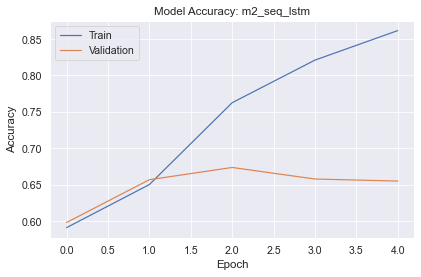

In [622]:
# extract history from model and plot epoch accuracy trend
m2_hist = m2_fit.history
plot_accuracy(m2_hist, m2.name)

In [623]:
# create predictions for model
yt_train_hat_m2, yt_train_hat_cl_m2 = predict(m2, Xt_train, yt_train)

In [624]:
# pivot 3 multi-labels into single class column to feed confusion matrix
yt_train_piv = create_pred_class(yt_train)
yt_train_hat_cl_m2_piv = create_pred_class(yt_train_hat_cl_m2)

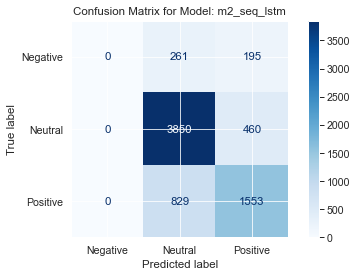

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       456
     Neutral       0.78      0.89      0.83      4310
    Positive       0.70      0.65      0.68      2382

    accuracy                           0.76      7148
   macro avg       0.49      0.52      0.50      7148
weighted avg       0.70      0.76      0.73      7148



/Users/cutterback/opt/anaconda3/envs/p37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cutterback/opt/anaconda3/envs/p37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cutterback/opt/anaconda3/envs/p37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [625]:
# plot confusion matrix and classification report
cnf_matrix_train_m2 = plot_confusion(yt_train_piv.pred_class, 
                               yt_train_hat_cl_m2_piv.pred_class,
                               m2.name)

In [626]:
# create predictions for model
y_test_hat_m2, y_test_hat_cl_m2 = predict(m2, Xt_test, yt_test)

In [627]:
# pivot 3 multi-labels into single class column to feed confusion matrix
yt_test_piv = create_pred_class(yt_test)
y_test_hat_cl_m2_piv = create_pred_class(y_test_hat_cl_m2)

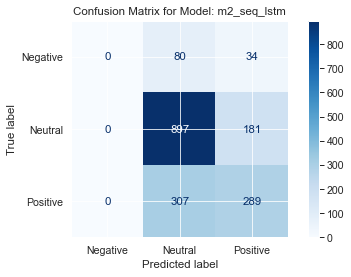

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       114
     Neutral       0.70      0.83      0.76      1078
    Positive       0.57      0.48      0.53       596

    accuracy                           0.66      1788
   macro avg       0.42      0.44      0.43      1788
weighted avg       0.61      0.66      0.63      1788



/Users/cutterback/opt/anaconda3/envs/p37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cutterback/opt/anaconda3/envs/p37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cutterback/opt/anaconda3/envs/p37env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [628]:
# plot confusion matrix and classification report
cnf_matrix_test_m2 = plot_confusion(yt_test_piv.pred_class, 
                               y_test_hat_cl_m2_piv.pred_class,
                               m2.name)

## m3 - LSTM Embed Glove

In [359]:
# establish total vocabulary prior to fetching Glove vectors
t0 = text.Tokenizer(oov_token=1)
t0.fit_on_texts(X)
vocab = list(t0.word_counts.keys())
print(f'Total tweet vocabulary is: {len(vocab)}')

Total tweet vocabulary is: 10563


In [360]:
# create glove dictionary of embedding vectors for vocab list
glove_file = 'data/glove.twitter.27B.200d.txt'
glove = {}
with open(glove_file, 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in vocab:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [361]:
# Number of dimensions of the GloVe word embeddings
glove_dim = len(next(iter(glove.values())))  

emb_matrix = np.zeros((vocab_size, glove_dim))
for w, i in X_tok.word_index.items():
    vect = glove.get(w)
    if vect is not None:
        emb_matrix[i] = vect

In [362]:
# instantiate keras sequential LSTM model layers with embeddings
m3 = Sequential(name="m3_seq_lstm_glove")
m3.add(Embedding(input_dim=vocab_size, 
                 output_dim=glove_dim, 
                 input_length=input_length,
                 weights=[emb_matrix], 
                 trainable=False
                    ))
m3.add(SpatialDropout1D(0.2))
m3.add(LSTM(128, return_sequences=True))
m3.add(Bidirectional(LSTM(128, dropout=0.15, recurrent_dropout=0.15, return_sequences=True)))
m3.add(GlobalMaxPool1D()) # downsamples input by taking the maximum value over the time dimension
m3.add(Dense(64, activation="relu")) 
m3.add(Dense(32, activation="relu"))
m3.add(Dense(3, activation='softmax'))

In [518]:
# compile model and print summary
opt = optimizers.Adam(learning_rate=0.001) 
m3.compile(loss='categorical_crossentropy', optimizer=opt,
              metrics=['accuracy'])
m3.summary()

Model: "m3_seq_lstm_glove"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 30, 200)           2113000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 30, 200)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 128)           168448    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 30, 256)           263168    
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_18 (Dense)             (None, 32)          

In [523]:
# Define the callbacks, early stopping and save final model
early_stop_m3 = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), 
                  ModelCheckpoint(filepath='best_model_m3.h5', monitor='val_loss',
                                  save_best_only=True)]
class_weights_m3 = [{0: 1, 1: 20}, {0: 1, 1: 1}, {0: 1, 1: 4}]

# optimizer=RMSprop(lr=learning_rate)
m3_fit = m3.fit(X_train, y_train, epochs=50, class_weight=class_weights_m3,
                callbacks=early_stop_m3, validation_split=0.15, shuffle=True,
                batch_size=128)
# sample_weight=weights,

Train on 6075 samples, validate on 1073 samples
Epoch 1/50
6075/6075 [==============================] - 30s 5ms/step - loss: 0.3278 - accuracy: 0.8617 - val_loss: 0.7389 - val_accuracy: 0.7064
Epoch 2/50
6075/6075 [==============================] - 30s 5ms/step - loss: 0.3241 - accuracy: 0.8640 - val_loss: 0.7601 - val_accuracy: 0.7185
Epoch 3/50
6075/6075 [==============================] - 30s 5ms/step - loss: 0.3077 - accuracy: 0.8728 - val_loss: 0.8592 - val_accuracy: 0.7083
Epoch 4/50
6075/6075 [==============================] - 30s 5ms/step - loss: 0.3014 - accuracy: 0.8731 - val_loss: 0.8135 - val_accuracy: 0.6962


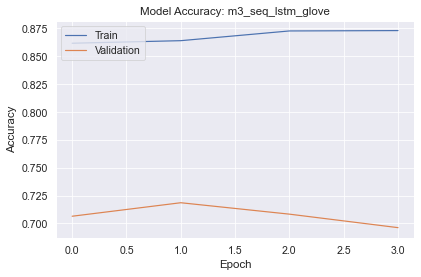

In [597]:
# extract history from model and plot epoch accuracy trend
m3_hist = m3_fit.history
plot_accuracy(m3_hist, m3.name)

In [527]:
# create predictions for model
y_train_hat_m3, y_train_hat_cl_m3 = predict(m3, X_train, y_train)

In [528]:
# pivot 3 multi-labels into single class column to feed confusion matrix
y_train_piv = create_pred_class(y_train)
y_train_hat_cl_m3_piv = create_pred_class(y_train_hat_cl_m3)

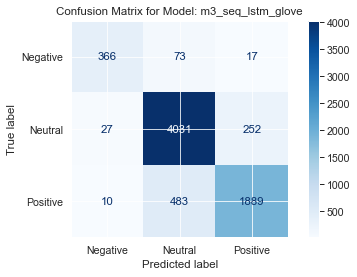

              precision    recall  f1-score   support

    Negative       0.91      0.80      0.85       456
     Neutral       0.88      0.94      0.91      4310
    Positive       0.88      0.79      0.83      2382

    accuracy                           0.88      7148
   macro avg       0.89      0.84      0.86      7148
weighted avg       0.88      0.88      0.88      7148



In [529]:
# plot confusion matrix and classification report
cnf_matrix_train_m3 = plot_confusion(y_train_piv.pred_class, 
                               y_train_hat_cl_m3_piv.pred_class,
                               m3.name)

In [485]:

Xy_train_m3 = pd.concat([y_train_piv.iloc[:, 3], y_train_hat_cl_m3_piv.iloc[:, 3], y_train_hat_m3, X], axis=1, join='inner')
Xy_train_m3.columns.values[0] = 'act_class'
Xy_train_m3.columns.values[2] = 'p_negative'
Xy_train_m3.columns.values[3] = 'p_neutral'
Xy_train_m3.columns.values[4] = 'p_positive'
Xy_train_m3

,act_class,pred_class,p_negative,p_neutral,p_positive,tweet_text_clean
6929,Neutral,Neutral,0.002,0.958,0.040,rt who is flying to #sxsw and wants some free miles dm meill shoot you a code currently iphone only
5841,Neutral,Neutral,0.002,0.935,0.063,rt google launching secret new social network called quotcirclesquot link #sxsw
2865,Negative,Negative,0.586,0.286,0.128,google prefers to launch hyped new social features with meh not bang via tc link #sxsw
4306,Neutral,Negative,0.441,0.419,0.140,luv rt best thing i heard this wknd at #sxsw quoti gave my ipad money to #japan relief dont need ipad quot
8888,Positive,Positive,0.061,0.276,0.663,i wish i were at #sxsw i wish i had an ipad there i said it
...,...,...,...,...,...,...
4594,Neutral,Neutral,0.009,0.619,0.372,money money money #apple heads to #sxsw sets up temporary store in austin link via
6975,Neutral,Positive,0.032,0.276,0.692,rt wow leo just told a random person on the street he would send her an ipad #twit #sxsw
7700,Neutral,Neutral,0.294,0.668,0.037,false alarm google circles not coming nowûòand probably not ever link more link #sxsw #sxswi
1476,Positive,Positive,0.004,0.047,0.949,brilliant rt apple set to open popup shop in core of sxsw action theyre going to sell ipad2 at #sxsw link


In [524]:
# create predictions for model
y_test_hat_m3, y_test_hat_cl_m3 = predict(m3, X_test, y_test)

In [525]:
# pivot 3 multi-labels into single class column to feed confusion matrix
y_test_piv = create_pred_class(y_test)
y_test_hat_cl_m3_piv = create_pred_class(y_test_hat_cl_m3)

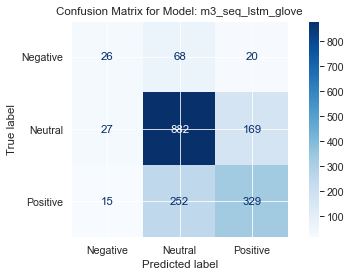

              precision    recall  f1-score   support

    Negative       0.38      0.23      0.29       114
     Neutral       0.73      0.82      0.77      1078
    Positive       0.64      0.55      0.59       596

    accuracy                           0.69      1788
   macro avg       0.58      0.53      0.55      1788
weighted avg       0.68      0.69      0.68      1788



In [526]:
# plot confusion matrix and classification report
cnf_matrix_test_m3 = plot_confusion(y_test_piv.pred_class, 
                               y_test_hat_cl_m3_piv.pred_class,
                               m3.name)